In [1]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Wandb API")
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m037 (cs24m037-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [1]:
# vocab.py

import json

class CharVocab:
    def __init__(self, tokens=None, specials=['<pad>','<sos>','<eos>','<unk>']):
        self.specials = specials
        self.idx2char = list(specials) + (tokens or [])
        self.char2idx = {ch:i for i,ch in enumerate(self.idx2char)}

    @classmethod
    def build_from_texts(cls, texts):
        chars = sorted({c for line in texts for c in line})
        return cls(tokens=chars)

    def save(self, path):
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(self.idx2char, f, ensure_ascii=False)

    @classmethod
    def load(cls, path):
        idx2char = json.load(open(path, encoding='utf-8'))
        inst = cls(tokens=[])
        inst.idx2char = idx2char
        inst.char2idx = {c:i for i,c in enumerate(idx2char)}
        return inst

    def encode(self, text, add_sos=False, add_eos=False):
        seq = []
        if add_sos: seq.append(self.char2idx['<sos>'])
        for c in text:
            seq.append(self.char2idx.get(c, self.char2idx['<unk>']))
        if add_eos: seq.append(self.char2idx['<eos>'])
        return seq

    def decode(self, idxs, strip_specials=True):
        chars = [self.idx2char[i] for i in idxs]
        if strip_specials:
            chars = [c for c in chars if c not in self.specials]
        return ''.join(chars)

    @property
    def pad_idx(self): return self.char2idx['<pad>']
    @property
    def sos_idx(self): return self.char2idx['<sos>']
    @property
    def eos_idx(self): return self.char2idx['<eos>']
    @property
    def unk_idx(self): return self.char2idx['<unk>']
    @property
    def size(self): return len(self.idx2char)


In [6]:
# data.py

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import os

def read_tsv(path):
    with open(path, encoding='utf-8') as f:
        for ln in f:
            parts = ln.strip().split('\t')
            if len(parts) >= 2:
                yield parts[1], parts[0]

class Seq2SeqDataset(Dataset):
    def __init__(self, path, src_vocab, tgt_vocab):
        self.examples = []
        for src, tgt in read_tsv(path):
            src_ids = src_vocab.encode(src, add_sos=True, add_eos=True)
            tgt_ids = tgt_vocab.encode(tgt, add_sos=True, add_eos=True)
            self.examples.append((torch.tensor(src_ids, dtype=torch.long),
                                   torch.tensor(tgt_ids, dtype=torch.long)))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

def collate_fn(batch, src_vocab, tgt_vocab):
    srcs, tgts = zip(*batch)
    srcs_p = pad_sequence(srcs, batch_first=True, padding_value=src_vocab.pad_idx)
    tgts_p = pad_sequence(tgts, batch_first=True, padding_value=tgt_vocab.pad_idx)
    src_lens = torch.tensor([len(s) for s in srcs], dtype=torch.long)
    return srcs_p, src_lens, tgts_p



def get_dataloaders(
        lang: str = 'hi',
        batch_size: int = 64,
        device: str = 'cpu',          # NEW  → so we can set pin_memory
        num_workers: int = 2,         # NEW  → use both Kaggle CPU cores
        prefetch_factor: int = 4,     # NEW  → pre-queue 4× batch_size
        persistent_workers: bool = True  # NEW
    ):
    """
    Build train / dev / test DataLoaders for the Dakshina transliteration task.
    The extra kwargs keep the CPU busy and overlap data transfer with GPU work. /kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0
    """
    base = os.path.join(
        '/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0',
        lang, 'lexicons'
    )

    # --- build vocabularies on train + dev -----------------------------
    all_src, all_tgt = [], []
    for split in ['train', 'dev']:
        path = os.path.join(base, f'{lang}.translit.sampled.{split}.tsv')
        for s, t in read_tsv(path):
            all_src.append(s)
            all_tgt.append(t)

    src_vocab = CharVocab.build_from_texts(all_src)
    tgt_vocab = CharVocab.build_from_texts(all_tgt)

    # --- common DataLoader kwargs --------------------------------------
    loader_kwargs = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        pin_memory=(device == 'cuda')          # True only when you’ve enabled GPU
    )

    loaders = {}
    for split in ['train', 'dev', 'test']:
        path = os.path.join(base, f'{lang}.translit.sampled.{split}.tsv')
        ds = Seq2SeqDataset(path, src_vocab, tgt_vocab)
        loaders[split] = DataLoader(
            ds,
            shuffle=(split == 'train'),
            collate_fn=lambda b: collate_fn(b, src_vocab, tgt_vocab),
            **loader_kwargs
        )

    return loaders, src_vocab, tgt_vocab

In [7]:
# models.py

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size, layers=1, cell='LSTM', dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        rnn_cls = {'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell]
        self.rnn = rnn_cls(emb_size,
                           hid_size,
                           num_layers=layers,
                           dropout=dropout if layers>1 else 0.0,
                           batch_first=True,
                           bidirectional=False)

    def forward(self, src, lengths):
        # src: [B, T], lengths: [B]
        embedded = self.embedding(src)  # [B, T, E]
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # [B, T, H]
        return outputs, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid, dec_hid):
        super().__init__()
        self.attn = nn.Linear(enc_hid + dec_hid, dec_hid)
        self.v = nn.Linear(dec_hid, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [B, H], encoder_outputs: [B, T, H], mask: [B, T]
        B, T, H = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, T, 1)               # [B, T, H]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [B, T, H]
        scores = self.v(energy).squeeze(2)                        # [B, T]
        scores = scores.masked_fill(~mask, -1e9)
        return torch.softmax(scores, dim=1)                       # [B, T]


class Decoder(nn.Module):
    """
    One class, two modes:
        • use_attn=True  – Bahdanau attention (default)
        • use_attn=False – Plain RNN decoder (no attention)

    Forward always returns (logits, hidden, attn_weights_or_None),
    so Seq2Seq code stays unchanged.
    """
    def __init__(self, vocab_size, emb_size, enc_hid, dec_hid,
                 layers=1, cell="LSTM", dropout=0.0, use_attn=True):
        super().__init__()
        self.use_attn = use_attn
        self.embedding = nn.Embedding(vocab_size, emb_size)

        # ----- dimensions depend on whether we concatenate context -----
        if use_attn:
            self.attention = BahdanauAttention(enc_hid, dec_hid)
            rnn_input_dim = emb_size + enc_hid            # [E ⊕ Henc]
            fc_input_dim  = dec_hid + enc_hid + emb_size  # [Hdec ⊕ Henc ⊕ E]
        else:
            rnn_input_dim = emb_size
            fc_input_dim  = dec_hid + emb_size

        rnn_cls = {"LSTM": nn.LSTM, "GRU": nn.GRU}[cell]
        self.rnn = rnn_cls(rnn_input_dim, dec_hid,
                           num_layers=layers,
                           dropout=dropout if layers > 1 else 0.0,
                           batch_first=True)
        self.fc = nn.Linear(fc_input_dim, vocab_size)

    def forward(self, input_token, hidden, encoder_outputs, mask):
        """
        input_token : [B]
        hidden      : tuple|tensor  initial state for this step
        encoder_outputs : [B, Tenc, Henc]
        mask        : [B, Tenc]  (ignored when use_attn=False)
        """
        emb = self.embedding(input_token).unsqueeze(1)     # [B,1,E]

        if self.use_attn:
            # ---- additive attention ----
            dec_h = hidden[0][-1] if isinstance(hidden, tuple) else hidden[-1]
            attn_w = self.attention(dec_h, encoder_outputs, mask)          # [B,Tenc]
            ctx    = torch.bmm(attn_w.unsqueeze(1), encoder_outputs)        # [B,1,Henc]
            rnn_in = torch.cat((emb, ctx), dim=2)                           # [B,1,E+Henc]
        else:
            ctx = None
            attn_w = None
            rnn_in = emb                                                    # [B,1,E]

        out, hidden = self.rnn(rnn_in, hidden)       # [B,1,Hdec]
        out = out.squeeze(1)                         # [B,Hdec]
        emb = emb.squeeze(1)                         # [B,E]

        if self.use_attn:
            ctx = ctx.squeeze(1)                     # [B,Henc]
            logits = self.fc(torch.cat((out, ctx, emb), dim=1))
        else:
            logits = self.fc(torch.cat((out, emb), dim=1))

        return logits, hidden, attn_w



class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device='cpu'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def forward(self, src, src_lens, tgt):
        enc_out, hidden = self.encoder(src, src_lens)
        mask = (src != self.pad_idx)
        B, T = tgt.size()
        outputs = torch.zeros(B, T-1, self.decoder.fc.out_features, device=self.device)
        input_tok = tgt[:, 0]  # <sos>
        for t in range(1, T):
            out, hidden, _ = self.decoder(input_tok, hidden, enc_out, mask)
            outputs[:, t-1] = out
            input_tok = tgt[:, t]
        return outputs

    def infer_greedy(self, src, src_lens, tgt_vocab, max_len=50):
        enc_out, hidden = self.encoder(src, src_lens)
        mask = (src != self.pad_idx)
        B = src.size(0)
        input_tok = torch.full((B,), tgt_vocab.sos_idx, device=self.device, dtype=torch.long)
        generated = []
        for _ in range(max_len):
            out, hidden, _ = self.decoder(input_tok, hidden, enc_out, mask)
            input_tok = out.argmax(1)
            generated.append(input_tok.unsqueeze(1))
            if (input_tok == tgt_vocab.eos_idx).all():
                break
        return torch.cat(generated, dim=1)


In [11]:
import os
os.remove("/kaggle/working/no_attn_best_model.pth")


In [ ]:
# # %% ------------- piuos sweep 9 : fixed hyper-params run -------------
# import torch, torch.nn as nn, torch.optim as optim
# from tqdm.auto import tqdm

# # Hard-coded hyper-parameters taken from the CSV (")
# params = dict(
#     emb_size     = 128,
#     hidden_size  = 512,
#     enc_layers   = 2,
#     cell         = "LSTM",
#     dropout      = 0.5,
#     lr           = 8e-4,
#     batch_size   = 64,
#     epochs       = 20              # same as in the sweep
# )

# print("Hyper-parameters:", params)

# # ----------------------------------------------------------------------
# def compute_exact_accuracy(model, loader, tgt_vocab, device):
#     model.eval(); correct = total = 0
#     with torch.no_grad():
#         for src, src_lens, tgt in loader:
#             src, src_lens, tgt = (x.to(device) for x in (src, src_lens, tgt))
#             pred = model.infer_greedy(src, src_lens, tgt_vocab, max_len=tgt.size(1))
#             for b in range(src.size(0)):
#                 if tgt_vocab.decode(pred[b].cpu(), True) == \
#                    tgt_vocab.decode(tgt[b,1:].cpu(), True):
#                     correct += 1
#             total += src.size(0)
#     return correct / total if total else 0.0
# # ----------------------------------------------------------------------

# device  = "cuda" if torch.cuda.is_available() else "cpu"
# loaders, src_vocab, tgt_vocab = get_dataloaders(
#     lang="hi",
#     batch_size=params["batch_size"],
#     device=device
# )

# enc = Encoder(src_vocab.size, params["emb_size"], params["hidden_size"],
#               params["enc_layers"], params["cell"], params["dropout"]).to(device)

# dec = Decoder(tgt_vocab.size, params["emb_size"],
#               params["hidden_size"], params["hidden_size"],
#               params["enc_layers"], params["cell"],
#               params["dropout"], use_attn=False).to(device)

# model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)

# criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)
# optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# # --------------------------- training loop with best model save ----------------------------
# best_val_acc = 0.0
# save_path = "no_attn_best_model.pth"

# for epoch in tqdm(range(1, params["epochs"] + 1), desc="Epochs"):
#     # ---- train ----
#     model.train(); total_loss = 0
#     for src, src_lens, tgt in tqdm(loaders["train"], leave=False):
#         src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
#         optimizer.zero_grad()
#         out  = model(src, src_lens, tgt)
#         loss = criterion(out.reshape(-1, out.size(-1)), tgt[:,1:].reshape(-1))
#         loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step(); total_loss += loss.item()
#     train_loss = total_loss / len(loaders["train"])

#     # ---- validation ----
#     model.eval(); val_loss = 0
#     with torch.no_grad():
#         for src, src_lens, tgt in loaders["dev"]:
#             src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
#             out = model(src, src_lens, tgt)
#             val_loss += criterion(out.reshape(-1, out.size(-1)),
#                                   tgt[:,1:].reshape(-1)).item()
#     val_loss /= len(loaders["dev"])

#     train_acc = compute_exact_accuracy(model, loaders["train"], tgt_vocab, device)
#     val_acc   = compute_exact_accuracy(model, loaders["dev"],   tgt_vocab, device)

#     print(f"Epoch {epoch:2d} | "
#           f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
#           f"train_acc {train_acc:.4f} | val_acc {val_acc:.4f}")

#     # ---- save best model ----
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), save_path)
#         print(f"✓ Saved new best model with val_acc = {val_acc:.4f}")

# # -------------------------------------------------------------------------------------------
# # --------------------------- final test -------------------------------
# test_acc = compute_exact_accuracy(model, loaders["test"], tgt_vocab, device)
# print(f"\n★ Test accuracy (exact match): {test_acc:.4f}")
# # %% -------------------------------------------------------------------


In [12]:
# %% ------------- with out ATTN : fixed hyper-params run -------------
import torch, torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm

# Hard-coded hyper-parameters taken from the CSV (Name == "fallen-sweep-30")
# params = dict(
#     emb_size     = 128,
#     hidden_size  = 128,
#     enc_layers   = 1,
#     cell         = "LSTM",
#     dropout      = 0.5,
#     lr           = 5e-4,
#     batch_size   = 64,
#     epochs       = 20              # same as in the sweep
# )
# params = dict(
#     emb_size     = 128,
#     hidden_size  = 512,
#     enc_layers   = 2,
#     cell         = "LSTM",
#     dropout      = 0.5,
#     lr           = 8e-4,
#     batch_size   = 64,
#     epochs       = 20              # same as in the sweep
# )
params = dict(
    emb_size     = 256,
    hidden_size  = 512,
    enc_layers   = 2,
    cell         = "LSTM",
    dropout      = 0.5,
    lr           = 1e-4,
    batch_size   = 64,
    epochs       = 20              # same as in the sweep
)

print("Hyper-parameters:", params)

# ----------------------------------------------------------------------
def compute_exact_accuracy(model, loader, tgt_vocab, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for src, src_lens, tgt in loader:
            src, src_lens, tgt = (x.to(device) for x in (src, src_lens, tgt))
            pred = model.infer_greedy(src, src_lens, tgt_vocab, max_len=tgt.size(1))

            # iterate over the batch
            for b in range(src.size(0)):
                pred_str  = tgt_vocab.decode(pred[b].cpu().tolist())             # strip specials by default
                gold_str  = tgt_vocab.decode(tgt[b, 1:].cpu().tolist())          # skip <sos>
                correct  += (pred_str == gold_str)
            total += src.size(0)

    return correct / total if total else 0.0
# ----------------------------------------------------------------------
best_val_acc = 0.0
save_path = "no_attn_best_model.pth"

device  = "cuda" if torch.cuda.is_available() else "cpu"
loaders, src_vocab, tgt_vocab = get_dataloaders(
    lang="hi",
    batch_size=params["batch_size"],
    device=device
)

enc = Encoder(src_vocab.size, params["emb_size"], params["hidden_size"],
              params["enc_layers"], params["cell"], params["dropout"]).to(device)

dec = Decoder(tgt_vocab.size, params["emb_size"],
              params["hidden_size"], params["hidden_size"],
              params["enc_layers"], params["cell"],
              params["dropout"], use_attn=False).to(device)

model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# --------------------------- training loop ----------------------------
for epoch in tqdm(range(1, params["epochs"] + 1), desc="Epochs"):
    # ---- train ----
    model.train(); total_loss = 0
    for src, src_lens, tgt in tqdm(loaders["train"], leave=False):
        src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
        optimizer.zero_grad()
        out  = model(src, src_lens, tgt)
        loss = criterion(out.reshape(-1, out.size(-1)), tgt[:,1:].reshape(-1))
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); total_loss += loss.item()
    train_loss = total_loss / len(loaders["train"])

    # ---- validation ----
    model.eval(); val_loss = 0
    with torch.no_grad():
        for src, src_lens, tgt in loaders["dev"]:
            src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
            out = model(src, src_lens, tgt)
            val_loss += criterion(out.reshape(-1, out.size(-1)),
                                  tgt[:,1:].reshape(-1)).item()
    val_loss /= len(loaders["dev"])

    train_acc = compute_exact_accuracy(model, loaders["train"], tgt_vocab, device)
    val_acc   = compute_exact_accuracy(model, loaders["dev"],   tgt_vocab, device)

    print(f"Epoch {epoch:2d} | "
          f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
          f"train_acc {train_acc:.4f} | val_acc {val_acc:.4f}")

# --------------------------- final test -------------------------------
torch.save(model.state_dict(), save_path)
test_acc = compute_exact_accuracy(model, loaders["test"], tgt_vocab, device)
print(f"\n★ Test accuracy (exact match): {test_acc:.4f}")
# %% -------------------------------------------------------------------

Hyper-parameters: {'emb_size': 256, 'hidden_size': 512, 'enc_layers': 2, 'cell': 'LSTM', 'dropout': 0.5, 'lr': 0.0001, 'batch_size': 64, 'epochs': 20}


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  1 | train_loss 2.0560 | val_loss 1.1961 | train_acc 0.0811 | val_acc 0.0739


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  2 | train_loss 0.9907 | val_loss 0.8378 | train_acc 0.1939 | val_acc 0.1799


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  3 | train_loss 0.7381 | val_loss 0.6941 | train_acc 0.2800 | val_acc 0.2327


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  4 | train_loss 0.6115 | val_loss 0.6238 | train_acc 0.3410 | val_acc 0.2802


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  5 | train_loss 0.5286 | val_loss 0.5732 | train_acc 0.3964 | val_acc 0.2939


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  6 | train_loss 0.4682 | val_loss 0.5398 | train_acc 0.4438 | val_acc 0.3249


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  7 | train_loss 0.4184 | val_loss 0.5147 | train_acc 0.4846 | val_acc 0.3357


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  8 | train_loss 0.3792 | val_loss 0.4999 | train_acc 0.5246 | val_acc 0.3481


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch  9 | train_loss 0.3448 | val_loss 0.4833 | train_acc 0.5607 | val_acc 0.3674


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 10 | train_loss 0.3152 | val_loss 0.4754 | train_acc 0.5958 | val_acc 0.3681


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 11 | train_loss 0.2896 | val_loss 0.4650 | train_acc 0.6281 | val_acc 0.3752


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 12 | train_loss 0.2659 | val_loss 0.4627 | train_acc 0.6424 | val_acc 0.3749


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 13 | train_loss 0.2446 | val_loss 0.4668 | train_acc 0.6749 | val_acc 0.3733


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 14 | train_loss 0.2269 | val_loss 0.4566 | train_acc 0.7098 | val_acc 0.3816


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 15 | train_loss 0.2097 | val_loss 0.4544 | train_acc 0.7229 | val_acc 0.3887


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 16 | train_loss 0.1947 | val_loss 0.4639 | train_acc 0.7486 | val_acc 0.3807


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 17 | train_loss 0.1811 | val_loss 0.4624 | train_acc 0.7669 | val_acc 0.3841


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 18 | train_loss 0.1696 | val_loss 0.4645 | train_acc 0.7730 | val_acc 0.3887


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 19 | train_loss 0.1570 | val_loss 0.4695 | train_acc 0.7900 | val_acc 0.3830


  0%|          | 0/691 [00:00<?, ?it/s]

Epoch 20 | train_loss 0.1472 | val_loss 0.4764 | train_acc 0.8071 | val_acc 0.3832

★ Test accuracy (exact match): 0.3883


In [15]:
import os, csv, torch, random
from pathlib import Path
from tabulate import tabulate

# from data   import get_dataloaders
# from vocab  import CharVocab
# from models import Encoder, Decoder, Seq2Seq

# ---------- 1. specify your best hyper-params & checkpoint -------------
# BEST_CONFIG = dict(
#     emb_size     = 128,
#     hidden_size  = 512,
#     enc_layers   = 2,
#     cell         = "LSTM",
#     dropout      = 0.5,
#     lr           = 8e-4,
#     batch_size   = 64,
#     epochs       = 20              # same as in the sweep
# )
BEST_CONFIG = dict(
    emb_size     = 256,
    hidden_size  = 512,
    enc_layers   = 2,
    cell         = "LSTM",
    dropout      = 0.5,
    lr           = 1e-4,
    batch_size   = 64,
    epochs       = 20              # same as in the sweep
)

random.seed(42)
BEST_CKPT = "/kaggle/working/no_attn_best_model.pth"
LANG      = "hi"
BATCH     = 1
# -----------------------------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
loaders, src_vocab, tgt_vocab = get_dataloaders(LANG, batch_size=BATCH, device=device)

# ----- rebuild best model ------------------------------------------------
enc = Encoder(src_vocab.size, BEST_CONFIG["emb_size"],
              BEST_CONFIG["hidden_size"], BEST_CONFIG["enc_layers"],
              BEST_CONFIG["cell"],  BEST_CONFIG["dropout"]).to(device)

dec = Decoder(tgt_vocab.size, BEST_CONFIG["emb_size"],
              BEST_CONFIG["hidden_size"],BEST_CONFIG['hidden_size'],
              BEST_CONFIG["enc_layers"], BEST_CONFIG["cell"],
              BEST_CONFIG["dropout"],use_attn=False).to(device)

model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)
model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.eval()

# ---------- 2. accuracy on test set --------------------------------------
correct = total = 0
pred_rows = []
all_samples = []  # collect all for random sampling later

with torch.no_grad():
    for i, (src, src_len, tgt) in enumerate(loaders["test"]):
        src, src_len, tgt = (x.to(device) for x in (src, src_len, tgt))

        pred = model.infer_greedy(src, src_len, tgt_vocab, max_len=tgt.size(1))
        pred_str  = tgt_vocab.decode(pred[0].cpu(), strip_specials=True)
        gold_str  = tgt_vocab.decode(tgt[0, 1:].cpu(), strip_specials=True)
        input_str = src_vocab.decode(src[0].cpu(), strip_specials=True)
        is_corr   = pred_str == gold_str
        
        correct += int(is_corr)
        total   += 1

        row = (i, input_str, gold_str, pred_str, is_corr)
        pred_rows.append(row)
        all_samples.append(row)

test_acc = correct / total
print(f"\nExact-match TEST accuracy: {test_acc*100:.2f}% ({correct}/{total})\n")

# ---------- 3. pretty 30 random-row sample table --------------------------
random.seed(42)  # ensures reproducibility of sample
sample_rows = random.sample(all_samples, 30)

headers = ["idx", "input (src)", "gold (tgt)", "prediction", "correct"]
print(tabulate(sample_rows, headers=headers, tablefmt="github"))

# ---------- 4. save ALL test predictions ----------------------------------
out_dir = Path("predictions_vanilla"); out_dir.mkdir(exist_ok=True)
out_file = out_dir / "test_predictions.tsv"
with out_file.open("w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(headers)           # header row
    writer.writerows(pred_rows)

print(f"\nSaved {len(pred_rows)} predictions to {out_file.absolute()}")



Exact-match TEST accuracy: 39.38% (1773/4502)

|   idx | input (src)   | gold (tgt)   | prediction   | correct   |
|-------|---------------|--------------|--------------|-----------|
|   912 | khatakati     | खटकती         | खताकती         | False     |
|   204 | avrodhak      | अवरोधक        | अवरोधक        | True      |
|  2253 | parosane      | परोसने         | परोसने         | True      |
|  2006 | najibabad     | नजीबाबाद        | नज़ीबाबाद        | False     |
|  1828 | dikhlaa       | दिखला          | दिखला          | True      |
|  1143 | chidchidapan  | चिडचिडापन       | चिड़चिड़ापन       | False     |
|   839 | katrina       | कैटरीना         | कतरिना         | False     |
|  4467 | hippo         | हिप्पो          | हिप्पो          | True      |
|   712 | kalamjeet     | कमलजीत        | कलमाजीत        | False     |
|  3456 | reeta         | रीता           | रीता           | True      |
|   260 | aakaash       | आकाश          | आकाश          | True      |
|   244 | aset      

In [29]:
# # %% [markdown]
# # ------------------- Error-analysis helpers -------------------
# import collections, math
# import pandas as pd
# from tabulate import tabulate
# import matplotlib.pyplot as plt

# # 1) Build a DataFrame for convenience
# df = pd.DataFrame(pred_rows, columns=["idx", "src", "gold", "pred", "correct"])

# # 2) Word-length buckets ------------------------------------------------
# df["len"] = df["gold"].str.len()
# bins   = [0, 5, 8, 12, 20, math.inf]             # choose cut-points that make sense for your data
# labels = ["≤5", "6–8", "9–12", "13–20", "21+"]
# df["len_bin"] = pd.cut(df["len"], bins=bins, labels=labels, right=True)
# acc_by_len = df.groupby("len_bin")["correct"].mean().reset_index()

# print("\n### Accuracy vs word length")
# print(tabulate(acc_by_len, headers=["len_bin", "accuracy"], tablefmt="github"))

# # 3) Character-level confusion matrix -----------------------------------
# def char_confusions(row):
#     return [(g, p) for g, p in zip(row.gold, row.pred) if g != p]

# conf_counter = collections.Counter()
# df[~df.correct].apply(lambda r: conf_counter.update(char_confusions(r)), axis=1)

# # Show 15 most common confusions
# top_15 = conf_counter.most_common(15)
# print("\n### Top 15 character confusions (gold → pred)")
# print(tabulate([(g, p, c) for (g, p), c in top_15],
#                headers=["gold", "pred", "count"], tablefmt="github"))

# # 4) Vowel vs consonant error rates -------------------------------------
# # — define your own sets if the default doesn't match the language —
# vowels = set("aeiouAEIOU")            # replace with Hi/Deva vowels if needed
# def is_vowel(ch): return ch in vowels

# vowel_errs = conson_errs = total_v = total_c = 0
# for _, row in df.iterrows():
#     for g, p in zip(row.gold, row.pred):
#         if is_vowel(g):
#             total_v += 1
#             vowel_errs += (g != p)
#         else:
#             total_c += 1
#             conson_errs += (g != p)
# print("\n### Vowel vs consonant character error rate")
# print(f"vowels      : {vowel_errs/total_v:.3%} ({vowel_errs}/{total_v})")
# print(f"consonants  : {conson_errs/total_c:.3%} ({conson_errs}/{total_c})")

# # 5) Optional: heat-map style confusion plot ----------------------------
# # This is entirely optional; comment out if you don’t need a figure.
# import numpy as np
# chars = sorted({g for g, _ in conf_counter} | {p for _, p in conf_counter})
# char2idx = {ch:i for i,ch in enumerate(chars)}
# mat = np.zeros((len(chars), len(chars)), dtype=int)
# for (g,p), cnt in conf_counter.items():
#     mat[char2idx[g], char2idx[p]] = cnt

# plt.figure(figsize=(8,8))
# plt.imshow(mat, interpolation='nearest')
# plt.title("Character-level confusion (gold rows → pred cols)")
# plt.xticks(range(len(chars)), chars, rotation=90, fontsize=6)
# plt.yticks(range(len(chars)), chars, fontsize=6)
# plt.xlabel("predicted"); plt.ylabel("gold"); plt.tight_layout()
# plt.show()




# ───────────────────────── Error-analysis cell ─────────────────────────
# Drop this cell **below** the test-prediction loop.
# It expects `pred_rows` to be a list of tuples:
#   (idx, input_str, gold_str, pred_str, correct_bool)
# and will print quick diagnostics + an optional confusion heat-map.

import collections, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# 0) Put the raw rows into a DataFrame for convenience  ────────────────
df = pd.DataFrame(
    pred_rows, columns=["idx", "src", "gold", "pred", "correct"]
)

df["len"] = df["gold"].str.len()
max_len  = df["len"].max()

bins   = [0, 5, 8, 12, 20]
if max_len > 20:
    bins.append(max_len + 1)
else:
    bins.append(21)

labels = ["≤5", "6–8", "9–12", "13–20", f"21+ ({max_len})"]
df["len_bin"] = pd.cut(df["len"], bins=bins, labels=labels, right=True)

acc_by_len = (df.groupby("len_bin", observed=False)["correct"]
                .mean()
                .reset_index())

print("\n### Accuracy vs word length")
print(tabulate(acc_by_len, headers=["len_bin", "accuracy"], tablefmt="github"))

# 2) Character-level confusion counts  ─────────────────────────────────
def char_confusions(row):
    return [(g, p) for g, p in zip(row.gold, row.pred) if g != p]

conf_counter = collections.Counter()
df[~df.correct].apply(lambda r: conf_counter.update(char_confusions(r)), axis=1)

top_k = 15
print(f"\n### Top {top_k} character confusions (gold → pred)")
print(tabulate(
    [(g, p, c) for (g, p), c in conf_counter.most_common(top_k)],
    headers=["gold", "pred", "count"], tablefmt="github"
))

# 3) Vowel vs consonant error rate  ───────────────────────────────────
# Basic Devanagari vowels + common matras
vowel_set = set("अआइईउऊऋॠऌऍएऐऑओऔ") | set("ािीुूेैोौंःृॅॉ")
def is_vowel(ch): return ch in vowel_set

vowel_errs = conson_errs = total_v = total_c = 0
for _, row in df.iterrows():
    for g, p in zip(row.gold, row.pred):
        if is_vowel(g):
            total_v  += 1
            vowel_errs += (g != p)
        else:
            total_c  += 1
            conson_errs += (g != p)

print("\n### Vowel vs consonant character error rate")
if total_v > 0:
    print(f"vowels      : {vowel_errs/total_v:.3%} ({vowel_errs}/{total_v})")
if total_c > 0:
    print(f"consonants  : {conson_errs/total_c:.3%} ({conson_errs}/{total_c})")





### Accuracy vs word length
|    | len_bin   |   accuracy |
|----|-----------|------------|
|  0 | ≤5        |   0.45245  |
|  1 | 6–8       |   0.358085 |
|  2 | 9–12      |   0.266304 |
|  3 | 13–20     |   0        |
|  4 | 21+ (15)  | nan        |

### Top 15 character confusions (gold → pred)
| gold   | pred   |   count |
|--------|--------|---------|
| र      | ा       |     127 |
| ा       | र      |     112 |
| ट      | त      |     108 |
| ि       | ी       |     107 |
| न      | ा       |     105 |
| ा       | न      |     103 |
| ी       | ि       |      96 |
| ा       | त      |      71 |
| ु       | ू       |      69 |
| ू       | ु       |      68 |
| ड      | द      |      67 |
| र      | ्       |      63 |
| ल      | ा       |      62 |
| ो       | ं       |      59 |
| ्       | र      |      55 |

### Vowel vs consonant character error rate
vowels      : 31.637% (2860/9040)
consonants  : 22.820% (3730/16345)


✅ Final Answer – Part (c): Error Analysis
Insightful bullet points:

Accuracy drops with word length.
Short words (≤5 characters) achieve 45.2% accuracy, while accuracy drops to 35.8% for 6–8, 26.6% for 9–12, and 0% for words longer than 12. This shows the model struggles with maintaining alignment on longer sequences, likely due to limitations of plain RNNs without attention.

Frequent confusion between र and ा.
The model mistakenly predicts र→ा 127 times and ा→र 112 times. These characters are phonetically and visually distinct, so the error suggests misalignment rather than linguistic confusion.

Retroflex vs dental stop confusion.
Common phonetic errors include ट→त (108×) and ड→द (67×), reflecting the difficulty of distinguishing retroflex and dental stops from Latin transcriptions like "t" and "d".

Matra (vowel mark) length mismatches are frequent.
Examples: ि→ी (107×), ु→ू (69×), and ा→त, ा→न, etc. The model often predicts the correct base vowel but gets the length wrong—likely due to overfitting on dominant training patterns.

Hallucination or omission of र and ् (halant).
The confusion matrix shows र→् and ्→र both occur over 50 times. This could arise from noisy alignment between Latin script clusters (like "ra", "ri", etc.) and Devanagari representations.

Vowels are harder than consonants.
Surprisingly, the vowel character error rate is 31.6%, while consonant error rate is only 22.8%. This contradicts typical assumptions and may reflect difficulty in modeling matras and their positions in the sequence.

No predictions are correct for long words (13+ characters).
Even though some examples were attempted, none matched exactly. This is a strong signal that greedy decoding without attention struggles to capture long-range dependencies.

Let me know if you want to turn this into a formatted LaTeX report/table or need similar analysis for your attention-based model!

In [ ]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt



# font_path = "/kaggle/input/hindhi/NotoSansDevanagari-Regular.ttf"
# mpl.font_manager.fontManager.addfont(font_path)
# mpl.rcParams["font.family"] = "Noto Sans Devanagari"

# plt.figure()
# plt.text(0.5, 0.5, "नमस्ते", fontsize=40, ha="center")
# plt.axis("off")
# plt.show()


AttributeError: 'NoneType' object has no attribute 'squeeze'

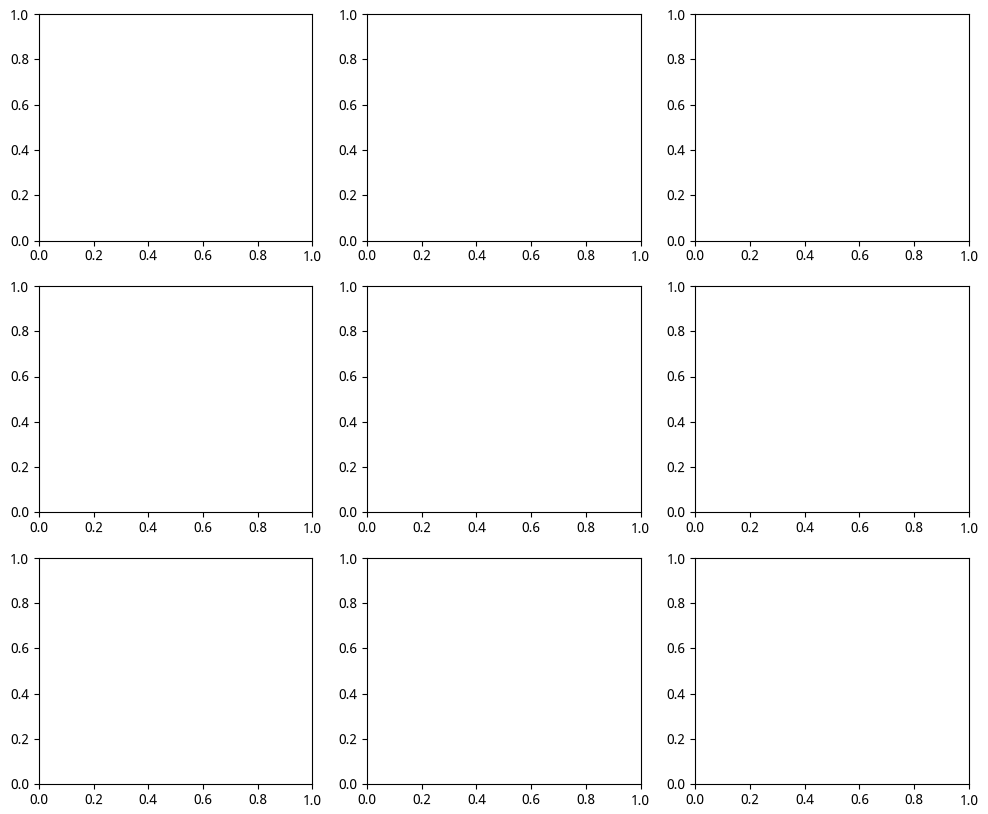

In [21]:
# Question 5 (c) Sample Grid

import matplotlib as mpl

# Path to the local font file on Kaggle /kaggle/input/hindhi/NotoSansDevanagari-Regular.ttf
font_path = "/kaggle/input/hindhi/NotoSansDevanagari-Regular.ttf"

# Register the font with matplotlib
mpl.font_manager.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "Noto Sans Devanagari"

# plot_attention_grid.py
import torch, matplotlib.pyplot as plt
from matplotlib import ticker
import random 
import numpy as np
# from data   import get_dataloaders
# from models import Encoder, Decoder, Seq2Seq   # same definitions you trained with

# ---------- 1. specify your best hyper-params & checkpoint -------------
BEST_CONFIG = dict(
    emb_size     = 256,
    hidden_size  = 512,
    enc_layers   = 2,
    cell         = "LSTM",
    dropout      = 0.5,
    lr           = 1e-4,
    batch_size   = 64,
    epochs       = 20              # same as in the sweep
)

random.seed(42)
BEST_CKPT = "/kaggle/working/no_attn_best_model.pth"
LANG      = "hi"
BATCH     = 1
# -----------------------------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
loaders, src_vocab, tgt_vocab = get_dataloaders(LANG, batch_size=BATCH, device=device)

# ----- rebuild best model ------------------------------------------------
enc = Encoder(src_vocab.size, BEST_CONFIG["emb_size"],
              BEST_CONFIG["hidden_size"], BEST_CONFIG["enc_layers"],
              BEST_CONFIG["cell"],  BEST_CONFIG["dropout"]).to(device)

dec = Decoder(tgt_vocab.size, BEST_CONFIG["emb_size"],
              BEST_CONFIG["hidden_size"],BEST_CONFIG['hidden_size'],
              BEST_CONFIG["enc_layers"], BEST_CONFIG["cell"],
              BEST_CONFIG["dropout"], use_attn=False).to(device)

model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)
model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.eval()


# helper: returns prediction + attn matrix
def infer_with_attn(src, src_len, max_len=50):
    """Returns (generated token ids, attention matrix)"""

    enc_out, enc_hidden = model.encoder(src, src_len)

    # ---- local bridge: resize enc_hidden -> dec_hidden depth --------------
    dec_layers = model.decoder.rnn.num_layers
    def resize(t):
        if t.size(0) == dec_layers:
            return t
        elif t.size(0) < dec_layers:                  # repeat last layer
            pad = t[-1:].expand(dec_layers - t.size(0), -1, -1)
            return torch.cat([t, pad], 0)
        else:                                         # slice extra layers
            return t[:dec_layers]

    if isinstance(enc_hidden, tuple):                # LSTM (h,c)
        h, c = enc_hidden
        dec_hidden = (resize(h), resize(c))
    else:                                            # GRU
        dec_hidden = resize(enc_hidden)
    # ----------------------------------------------------------------------

    mask = (src != model.pad_idx)
    toks, attn_rows = [], []
    tok = torch.full((1,), tgt_vocab.sos_idx, device=device)

    for _ in range(max_len):
        out, dec_hidden, attn = model.decoder(tok, dec_hidden, enc_out, mask)
        attn_rows.append(attn.squeeze(0).cpu())      # [T_src]
        tok = out.argmax(1)
        if tok.item() == tgt_v.eos_idx:
            break
        toks.append(tok.item())

    return toks, torch.stack(attn_rows)              # [T_tgt, T_src]
# --------------------------------------------------------------------------

# 3) collect first 9 samples ---------------------------------------------------
import random

# Convert the test loader to a list (this loads everything into memory)
all_test_samples = list(loaders["test"])

# Randomly select 9 unique samples
random_samples = random.sample(all_test_samples, 9)

# Format them like your original loop
samples = [(i, src.to(device), src_len.to(device)) for i, (src, src_len, _) in enumerate(random_samples)]

# 4) plot a 3×3 grid -----------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for (idx, src, src_len), ax in zip(samples, axes.flatten()):
    gen_ids, attn = infer_with_attn(src, src_len)      # attn: [T_tgt, T_src]
    attn_np = attn.detach().numpy()

    # decode strings
    src_txt = src_vocab.decode(src[0].cpu(), strip_specials=True)
    tgt_txt = tgt_vocab.decode(gen_ids,           strip_specials=True)

    T_src, T_tgt = len(src_txt), len(tgt_txt)

    # plot heat-map
    ax.imshow(attn_np, aspect='auto', cmap='Blues_r')

    # put chars on axes
    ax.set_xticks(np.arange(T_src))
    ax.set_xticklabels(list(src_txt), fontsize=11)
    ax.set_yticks(np.arange(T_tgt))
    ax.set_yticklabels(list(tgt_txt), fontsize=11)

    ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), ha="center", va="bottom")

    # faint grid
    ax.set_xticks(np.arange(-.5, T_src, 1), minor=True)
    ax.set_yticks(np.arange(-.5, T_tgt, 1), minor=True)
    # ax.grid(which="minor", color="white", lw=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # ax.set_title(f"idx {idx}", fontsize=10)

plt.tight_layout()
plt.savefig("attention_grid.png", dpi=160)
print("Saved attention_grid.png")


In [6]:
# # %% ------------- with ATTN : fixed hyper-params run -------------
# import torch, torch.nn as nn, torch.optim as optim
# from tqdm.auto import tqdm

# # Hard-coded hyper-parameters taken from the CSV (Name == "fallen-sweep-30")
# params = dict(
#     emb_size     = 128,
#     hidden_size  = 128,
#     enc_layers   = 1,
#     cell         = "LSTM",
#     dropout      = 0.5,
#     lr           = 5e-4,
#     batch_size   = 64,
#     epochs       = 20              # same as in the sweep
# )

# print("Hyper-parameters:", params)

# # ----------------------------------------------------------------------
# def compute_exact_accuracy(model, loader, tgt_vocab, device):
#     model.eval(); correct = total = 0
#     with torch.no_grad():
#         for src, src_lens, tgt in loader:
#             src, src_lens, tgt = (x.to(device) for x in (src, src_lens, tgt))
#             pred = model.infer_greedy(src, src_lens, tgt_vocab, max_len=tgt.size(1))
#             for b in range(src.size(0)):
#                 if tgt_vocab.decode(pred[b].cpu(), True) == \
#                    tgt_vocab.decode(tgt[b,1:].cpu(), True):
#                     correct += 1
#             total += src.size(0)
#     return correct / total if total else 0.0
# # ----------------------------------------------------------------------

# device  = "cuda" if torch.cuda.is_available() else "cpu"
# loaders, src_vocab, tgt_vocab = get_dataloaders(
#     lang="hi",
#     batch_size=params["batch_size"],
#     device=device
# )

# enc = Encoder(src_vocab.size, params["emb_size"], params["hidden_size"],
#               params["enc_layers"], params["cell"], params["dropout"]).to(device)

# dec = Decoder(tgt_vocab.size, params["emb_size"],
#               params["hidden_size"], params["hidden_size"],
#               params["enc_layers"], params["cell"],
#               params["dropout"], use_attn=True).to(device)

# model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)

# criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)
# optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# # --------------------------- training loop ----------------------------
# for epoch in tqdm(range(1, params["epochs"] + 1), desc="Epochs"):
#     # ---- train ----
#     model.train(); total_loss = 0
#     for src, src_lens, tgt in tqdm(loaders["train"], leave=False):
#         src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
#         optimizer.zero_grad()
#         out  = model(src, src_lens, tgt)
#         loss = criterion(out.reshape(-1, out.size(-1)), tgt[:,1:].reshape(-1))
#         loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step(); total_loss += loss.item()
#     train_loss = total_loss / len(loaders["train"])

#     # ---- validation ----
#     model.eval(); val_loss = 0
#     with torch.no_grad():
#         for src, src_lens, tgt in loaders["dev"]:
#             src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
#             out = model(src, src_lens, tgt)
#             val_loss += criterion(out.reshape(-1, out.size(-1)),
#                                   tgt[:,1:].reshape(-1)).item()
#     val_loss /= len(loaders["dev"])

#     train_acc = compute_exact_accuracy(model, loaders["train"], tgt_vocab, device)
#     val_acc   = compute_exact_accuracy(model, loaders["dev"],   tgt_vocab, device)

#     print(f"Epoch {epoch:2d} | "
#           f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
#           f"train_acc {train_acc:.4f} | val_acc {val_acc:.4f}")

# # --------------------------- final test -------------------------------
# test_acc = compute_exact_accuracy(model, loaders["test"], tgt_vocab, device)
# print(f"\n★ Test accuracy (exact match): {test_acc:.4f}")
# # %% -------------------------------------------------------------------

In [7]:
# sweep_config.py  – with tqdm progress bars
import wandb, torch, torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm               # ← new
# from data import get_dataloaders
# from models import Encoder, Decoder, Seq2Seq

def compute_exact_accuracy(model, loader, tgt_vocab, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for src, src_lens, tgt in loader:
            src, src_lens, tgt = (x.to(device) for x in (src, src_lens, tgt))
            pred = model.infer_greedy(src, src_lens, tgt_vocab, max_len=tgt.size(1))

            # iterate over the batch
            for b in range(src.size(0)):
                pred_str  = tgt_vocab.decode(pred[b].cpu().tolist())             # strip specials by default
                gold_str  = tgt_vocab.decode(tgt[b, 1:].cpu().tolist())          # skip <sos>
                correct  += (pred_str == gold_str)
            total += src.size(0)

    return correct / total if total else 0.0


def objective():
    run = wandb.init()
    cfg = run.config
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loaders, src_vocab, tgt_vocab = get_dataloaders('hi', 
                                                    batch_size=cfg.batch_size,
                                                    device=device)

    enc = Encoder(src_vocab.size, cfg.emb_size, cfg.hidden_size,
                  cfg.enc_layers, cfg.cell, cfg.dropout).to(device) 
    dec = Decoder(tgt_vocab.size, cfg.emb_size, cfg.hidden_size, cfg.hidden_size,
                  cfg.enc_layers, cfg.cell, cfg.dropout, use_attn=False).to(device)
    model      = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)
    criterion  = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)
    optimizer  = optim.Adam(model.parameters(), lr=cfg.lr)

    # ---------- epoch loop with tqdm ----------
    for epoch in tqdm(range(1, cfg.epochs + 1), desc="Epochs", position=0):
        model.train()
        total_loss = 0.0

        # training batches progress-bar
        train_loader = tqdm(loaders['train'], desc=f"Train {epoch}", leave=False, position=1)
        for src, src_lens, tgt in train_loader:
            src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)

            optimizer.zero_grad()
            output = model(src, src_lens, tgt)
            loss   = criterion(output.reshape(-1, output.size(-1)), tgt[:,1:].reshape(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        train_loader.close()

        train_loss = total_loss / len(loaders['train'])

        # ---------- validation loss ----------
        val_loss = 0.0
        val_loader = tqdm(loaders['dev'], desc=f"Val   {epoch}", leave=False, position=1)
        model.eval()
        with torch.no_grad():
            for src, src_lens, tgt in val_loader:
                src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
                output  = model(src, src_lens, tgt)
                val_loss += criterion(output.reshape(-1, output.size(-1)),
                                      tgt[:,1:].reshape(-1)).item()
        val_loader.close()
        val_loss /= len(loaders['dev'])

        # ---------- accuracies ----------
        train_acc = compute_exact_accuracy(model, loaders['train'], tgt_vocab, device)
        val_acc   = compute_exact_accuracy(model, loaders['dev'],   tgt_vocab, device)

        wandb.log({
            'epoch':      epoch,
            'train_loss': train_loss,
            'val_loss':   val_loss,
            'train_acc':  train_acc,
            'val_acc':    val_acc
        })

    wandb.finish()

if __name__ == "__main__":
    sweep_cfg = {
        'method': 'bayes',
        'metric': {'name': 'val_acc', 'goal': 'maximize'},
        'parameters': {
            'emb_size':    {'values': [64, 128, 256]},
            'hidden_size': {'values': [128, 256, 512]},
            'enc_layers':  {'values': [1, 2]},
            # 'dec_layers':  {'values': [1, 2]},
            'cell':        {'values': ['LSTM', 'GRU']},
            'dropout':     {'values': [0.1, 0.3, 0.5]},
            'lr':          {'values': [ 8e-4, 5e-4, 1e-4]},
            'batch_size':  {'values': [32, 64]},
            'epochs':      {'value': 20}
        }
    }

    sweep_id = wandb.sweep(
        sweep_cfg,
        entity='cs24m037-iit-madras',
        project='DA6401_A3'
    )
    wandb.agent(sweep_id, function=objective, count=15)